In [1]:
#!/usr/bin/env python
"""
Created December 10, 2022 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha and Connor Sanderford"
__copyright__ = "Copyright 2022, TRIPs-Py library"
__license__ = "GPL"
__version__ = "0.1"
__maintainer__ = "Mirjeta Pasha and Connor Sanderford"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com and csanderf@asu.edu; connorsanderford@gmail.com"

#### Import the methods and functions needed

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import matplotlib
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
import scipy.special as spe
import matplotlib.pyplot as plt

In [3]:
class Deblurring:
    def __init__(self,**kwargs):
        seed = kwargs.pop('seed',2022)
    def Gauss(self, PSFdim, PSFspread):
        self.m = PSFdim[0]
        self.n = PSFdim[1]
        self.dim = PSFdim
        self.spread = PSFspread
        self.s1, self.s2 = PSFspread, PSFspread
        # Set up grid points to evaluate the Gaussian function
        x = np.arange(-np.fix(self.n/2), np.ceil(self.n/2))
        y = np.arange(-np.fix(self.m/2), np.ceil(self.m/2))
        X, Y = np.meshgrid(x, y)
        # Compute the Gaussian, and normalize the PSF.
        PSF = np.exp( -0.5* ((X**2)/(self.s1**2) + (Y**2)/(self.s2**2)) )
        PSF /= PSF.sum()
        # find the center
        mm, nn = np.where(PSF == PSF.max())
        center = np.array([mm[0], nn[0]])
        return PSF, center.astype(int)

    def forward_Op(self, dim, spread, nx, ny):
        PSF, center = self.Gauss(dim, spread)
        proj_forward = lambda X: convolve(X.reshape([nx,ny]), PSF, mode='constant').flatten()
        proj_backward = lambda B: convolve(B.reshape([nx,ny]), np.flipud(np.fliplr(PSF)), mode='constant' ).flatten()
        blur = pylops.FunctionOperator(proj_forward, proj_backward, nx*ny)
        return blur

    def generate_true(self, choose_image):
        # Specify the path
        path_package = '/Users/mirjetapasha/Documents/Research_Projects/TRIPS_June25/multiparameter_package'
        if choose_image == 'satellite128':
            dataa = spio.loadmat(path_package + '/demos/data/images/satellite128.mat')
            X = dataa['x_true']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.flatten(order = 'F')
        elif choose_image == 'satellite64':
            dataa = spio.loadmat(path_package + '/demos/data/images/satellite64.mat')
            X = dataa['x_new']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.flatten(order = 'F')
        elif choose_image == 'edges':
            dataa = spio.loadmat(path_package + '/demos/data/images/edges.mat')
            X = dataa['x']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.flatten(order = 'F')
        elif choose_image == 'pattern1':
            dataa = spio.loadmat(path_package + '/demos/data/images/shape1.mat')
            X = dataa['xtrue']
            X_true = X/X.max()
            self.nx, self.ny = X_true.shape  
            x_truef = X_true.flatten(order = 'F')
        elif choose_image == 'Himage':
            dx = 10
            dy = 10
            up_width = 10
            bar_width= 5
            size = 64
            self.nx, self.ny = 64, 64
            h_im = np.zeros((size, size))
            for i in range(size):
                if i < dy or i > size-dy:
                    continue
                for j in range(size):
                    if j < dx or j > size - dx:
                        continue
                    if j < dx + up_width or j > size - dx - up_width:
                        h_im[i, j] = 1
                    if abs(i - size/2) < bar_width:
                        h_im[i, j] = 1
            x_truef = self.vec(h_im)
            # X_true = h_im
        else:
            raise ValueError("The image you requested does not exist! Specify the right name.")
        return (x_truef, self.nx, self.ny)
        ## convert a 2-d image into a 1-d vector
    def vec(self, image):
        sh = image.shape
        return image.reshape((sh[0]*sh[1]))

    ## convert a 1-d vector into a 2-d image of the given shape
    def im(self, x, shape):
        return x.reshape(shape)

    ## display a 1-d vector as a 2-d image
    def display_vec(self, vec, shape, scale = 1):
        image = self.im(vec, shape)
        plt.imshow(image, vmin=0, vmax=scale * np.max(vec), cmap='gray')
        plt.axis('off')
        plt.show()
    
        ## a helper function for creating the blurring operator
    def get_column_sum(self, spread):
        length = 40
        raw = np.array([np.exp(-(((i-length/2)/spread[0])**2 + ((j-length/2)/spread[1])**2)/2) 
                        for i in range(length) for j in range(length)])
        return np.sum(raw[raw > 0.0001])

    ## blurs a single pixel at center with a specified Gaussian spread

    def P(self, spread, center, shape):
        image = np.zeros(shape)
        for i in range(shape[0]):
            for j in range(shape[1]):
                v = np.exp(-(((i-center[0])/spread[0])**2 + ((j-center[1])/spread[1])**2)/2)
                if v < 0.0001:
                    continue
                image[i,j] = v
        return image

    def forward_Op_matrix(self, spread, shape, nx, ny):
        ## construct our blurring matrix with a Gaussian spread and zero boundary conditions
        #normalize = get_column_sum(spread)
        m = shape[0]
        n = shape[1]
        A = np.zeros((m*n, m*n))
        count = 0
        self.spread = spread
        self.shape = shape
        for i in range(m):
            for j in range(n):
                column = self.vec(self.P(spread, [i, j],  shape))
                A[:, count] = column
                count += 1
        normalize = np.sum(A[:, int(m*n/2 + n/2)])
        A = 1/normalize * A
        return A

    def generate_data(self, x, matrix):
        if matrix == False:
            A = self.forward_Op(self.dim, self.spread, self.nx, self.ny)
            b = A*x
        else:
            A = self.forward_Op_matrix(self.spread, self.shape, self.nx, self.ny)
            b = A@x
        return b
        
    def add_noise(self, b_true, opt, noise_level):
        if (opt == 'Gaussian'):
            mu_obs = np.zeros(self.nx*self.ny)      # mean of noise
            e = np.random.randn(self.nx*self.ny)
            delta = np.linalg.norm(e)
            sig_obs = noise_level * np.linalg.norm(b_true)/np.linalg.norm(e)
            b_meas = b_true + sig_obs*e
            b_meas_im = b_meas.reshape((self.nx, self.ny), order='F')
        return (b_meas_im, delta)

In [4]:
def TruncatedSVD_sol(A, k, b_vec):
  U, S, VT = np.linalg.svd(A)
  S_hat = S[0:k] #extract the first r singular values
  S_hat_mat = np.diag(S_hat) #form a diagonal matrix
  U_temp = U[:, 0:k]
  x_trunc = np.transpose(VT[0:k, :])@np.linalg.inv(S_hat_mat)@np.transpose(U_temp)@b_vec
  return x_trunc

Step 1: Generate a small deblurring example

In [5]:
# Deblurring example test problem
Deblur = Deblurring()
# In the class Deblurring we have can define the type of problem to be used.
generate_matrix = True #Defines a blurring operator where the forward operator matrix is formed explicitly
imagesize_x = 64 # Define the first dimension of the image
imagesize_y = 64 # Defines the second dimension of the image
spread = 2 # The PSF parameter
choose_image = 'pattern1' #The choice of the image
if generate_matrix == True:
        size = imagesize_x
        shape = (size, size)
        spreadnew = (spread, spread)
        A = Deblur.forward_Op_matrix(spreadnew, shape, imagesize_x, imagesize_y)
(x_true, nx, ny) = Deblur.generate_true(choose_image)
b_true = Deblur.generate_data(x_true, generate_matrix)
(b, delta) = Deblur.add_noise(b_true, 'Gaussian', noise_level = 0.01)

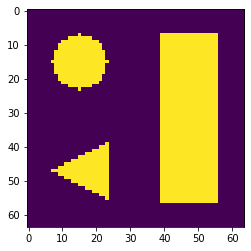

In [6]:
plt.imshow(x_true.reshape((64, 64)))

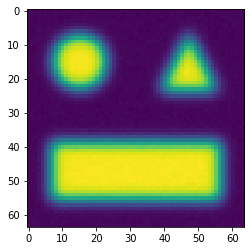

In [7]:
plt.imshow(b.reshape((64, 64)))

#### Compute the truncated SVD solution of a problem by specifying how many singular values you want to keep after truncation

(-0.5, 63.5, 63.5, -0.5)

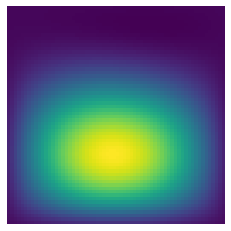

In [9]:
truncated_value = 3
b_vec = b.reshape((-1,1))
x_tsvd = TruncatedSVD_sol(A, truncated_value, b_vec)
plt.imshow(x_tsvd.reshape((imagesize_x, imagesize_y)))
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

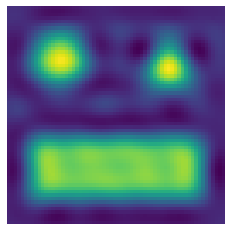

In [10]:
k = 100
b_vec = b.reshape((-1,1))
x_tsvd = TruncatedSVD_sol(A, k, b_vec)
plt.imshow(x_tsvd.reshape((imagesize_x, imagesize_y)))
plt.axis('off')